In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
import scipy
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.tsatools import freq_to_period
import math
import warnings
import copy
import statsmodels.datasets
warnings.filterwarnings("ignore")
class STF_reflected:

    # init method or constructor 
    def __init__(self, data, window, period = None, pad = None, seasonal = None):
        self.data = data
        self.window = window
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = pad
        if seasonal is not None:
            if seasonal % 2 == 0 or seasonal < 3:
                raise ValueError("seasonal must be an odd positive integer >= 3")
        self.seasonal = seasonal
    
    def optimize_seasonal_window(self):
        # Create variables to hold the lowest correlation 
        best_corr = 1
        # Create copies of fhat and fhat_seasonal for correlation calculations
        fhat = copy.copy(self.fhat)
        fhat_seasonal = copy.copy(self.fhat_seasonal)
        # Loop through odd seasonal numbers from 3 to 45
        for i in range(3, 35, 2):
            filter_cutoff = 1.5*(i)*(1/self.period)
            fhat[self.freq >= filter_cutoff] = 0
            
            # Filter freqs for seasonal (high pass filter)
            fhat_seasonal[self.freq < filter_cutoff] = 0
            # Find pearsonr from fhat and fhat_seasonal
            corr = np.corrcoef(fhat.real, fhat_seasonal.real)[0][1]
            if corr < best_corr:
                best_corr = corr
                self.seasonal = i
        return self
                
            
    def fit(self):
        
        dt = 1 / (self.period)
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        half = np.floor(len(t)/2)
        # Reflect f onto f on both tails
        #TODO: Try reflecting only half the window width on both ends
        reflected = np.append(np.flip(f), f)
        reflected = np.append(reflected, np.flip(f))
        
        #TODO: Figure out why this is right here
        self.observed = pd.Series(self.data.squeeze(), self.data.index)


        n = len(reflected) 
        #Compute FFT
        #TODO: Return fhat to see exactly what is being returned for fft (are they frequencies?)
        #TODO: Test rfft instead of fft
        self.fhat = np.fft.fft(reflected, n)
        self.fhat_seasonal = copy.copy(self.fhat)
        

        if self.window == "tukey":
            window = signal.tukey(n, alpha = self.pad)
        else:
            window = get_window(self.window, n)
        
        # X axis of freqs
        self.freq = (1 / (dt*n)) * np.arange(n)

        # Apply window to freqs
        self.freq = self.freq*window

        # Filter freqs for trend (low pass filter from Celevaland 1990) 
        if self.seasonal != None:
            filter_cutoff = 1.5*(1/self.seasonal)*(1/self.period)
            
            self.fhat[self.freq >= filter_cutoff] = 0

            # Filter freqs for seasonal (high pass filter)
            self.fhat_seasonal[self.freq < filter_cutoff] = 0
        else:
            self.optimize_seasonal_window()
            filter_cutoff = 1.5*(1/self.seasonal)*(1/self.period)

            self.fhat[self.freq >= filter_cutoff] = 0
            # Filter freqs for seasonal (high pass filter)
            self.fhat_seasonal[self.freq < filter_cutoff] = 0


        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(self.fhat)
        ffilt_seasonal = np.fft.ifft(self.fhat_seasonal)

        # Remove reflected padding
        ffilt = ffilt[len(f): (len(f)*2)]
        ffilt_seasonal = ffilt_seasonal[len(f): len(f)*2]
     
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # This will be res.seasonal (ffilt_seasonal)
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        residual = self.observed - ffilt_seasonal.real - ffilt.real
        resid = pd.Series(residual, self.data.index, name = "resid")

        # TODO: See if this is necessary for returning DecomposeResult()
        rw = pd.Series(np.ones(len(season)), self.data.index, name="robust_weight")
      
        # Initial Statistical Summary
       # print("The rmse", math.sqrt(mean_squared_error(co2["CO2"], (ffilt_seasonal + ffilt).real)))
        #print("The dot product of STF seasonal and trend components is ", np.round(ffilt_seasonal.dot(ffilt)))
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid, rw)

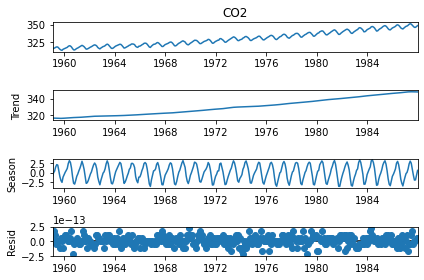

In [73]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

stf = STF_reflected(co2, "blackman")
res = stf.fit()
fig = res.plot()

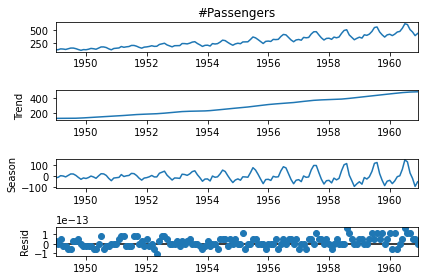

In [77]:
air = pd.read_csv('../data/AirPassengers.csv', index_col = "Month", parse_dates=True, squeeze=True)

stf = STF_reflected(air, "blackman", pad = .5)
res = stf.fit()
fig = res.plot()

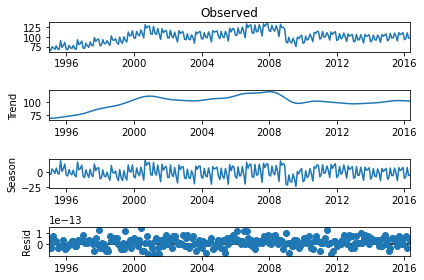

In [75]:
# Test stf vs stl on elec_equip data 
from statsmodels.datasets import elec_equip as ds
elec_equip = ds.load().data
stf = STF_reflected(elec_equip, "blackman", pad = 1)
res = stf.fit()
fig = res.plot()